# Predicting Financial Time Series Data with Machine Learning

This is a sample that predicts future prices from past price movements.
Here we implement it with EUR/USD rate as an example, but you can convert it to stock price by editing the symbol.

*** disclaimer
The information and materails provided here are not intended to be and do not constitute financial advice, investment advice, trading advice or any other advice or recommendation of any sort.

In [0]:
import datetime
import numpy as np
import pandas as pd
# from matplotlib.finance import quotes_historical_yahoo_ochl

In [0]:
#from mplfinance import candlestick_ohlc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display
%matplotlib inline

In [0]:
import pandas as pd
import pandas_datareader as pdr
import datetime as dt

start = dt.datetime(2008,1,1)
end = dt.datetime(2016,12,31)

df = pdr.DataReader('TSLA', 'yahoo', start, end)
# print(df.head())

In [19]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-12-23,213.449997,207.710007,208.000000,213.339996,4670500,213.339996
2016-12-27,222.250000,214.419998,214.880005,219.529999,5915700,219.529999
2016-12-28,223.800003,217.199997,221.529999,219.740005,3782500,219.740005
2016-12-29,219.199997,214.119995,218.559998,214.679993,4045000,214.679993
2016-12-30,217.500000,211.679993,216.300003,213.690002,4642600,213.690002


In [0]:
df.rename(columns={'Adj Close':'aclose', 'High':'high','Low':'low','Open':'open','Close':'close'},
         inplace=True)

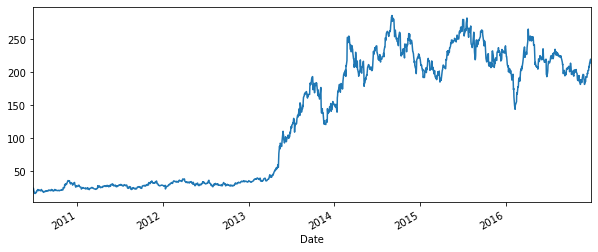

In [21]:
df['close'].plot(figsize=(10,4))

,high,low,open,close,Volume,aclose,return,label
Date,,,,,,,,
2016-12-23,213.449997,207.710007,208.000000,213.339996,4670500,213.339996,4.889999,1
2016-12-27,222.250000,214.419998,214.880005,219.529999,5915700,219.529999,6.190002,1
2016-12-28,223.800003,217.199997,221.529999,219.740005,3782500,219.740005,0.210007,0
2016-12-29,219.199997,214.119995,218.559998,214.679993,4045000,214.679993,-5.060013,0
2016-12-30,217.500000,211.679993,216.300003,213.690002,4642600,213.690002,-0.989990,0


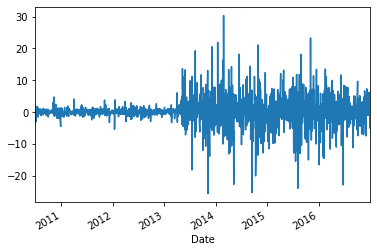

In [23]:
# Normalize aclose value
# We use this value to train model
df['return'] = df['aclose'] - df['aclose'].shift(1)
df['return'].plot()

# Make label, 1 as rising price, 0 as falling price
df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
# df.dropna(inplace=True)
df.tail()

In [28]:
# Make training dataset
n_features = 60 # number of features

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    if i<n_features:
        continue
    _x = np.array(df[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    _y = df.ix[i]['label']
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


(1580, 60)
(1580,)
% of Class0 : 0.487342
% of Class1 : 0.512658


In [0]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
def model_scoring(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("======================================")
    print("======Model Performance===============")

    print("the accuracy is: ", accuracy)
    print("the precision is：",precision)
    print("the recall is: ", recall)
    print("the f1 score is: ", f1)
    print("confution matrix: \n", confusion_matrix(y_test, y_pred))

In [30]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
model_scoring(y_test, y_pred)

======Model Performance===============
the accuracy is:  0.5316455696202531
the precision is： 0.5280898876404494
the recall is:  0.5949367088607594
the f1 score is:  0.5595238095238095
confution matrix: 
 [[74 84]
 [64 94]]


,return,label,pred,won,pnl,equity
310,0.309998,1.0,1.0,True,30.999756,7125.011063
311,7.250000,1.0,0.0,False,-725.000000,6400.011063
312,7.600006,0.0,1.0,False,-760.000610,5640.010452
313,-1.119995,0.0,1.0,False,-111.999512,5528.010941
314,9.950012,0.0,0.0,True,995.001221,6523.012161


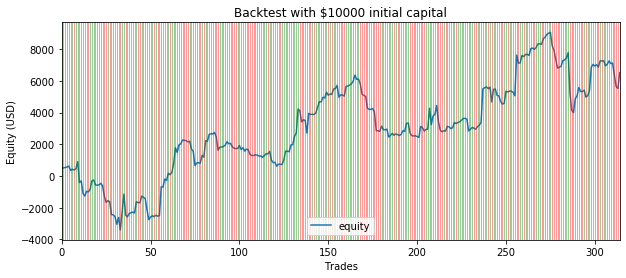

In [36]:
# Calculate equity..
initial_cash = 2400
contracts  = 100
commission = 0.0

df_trade = pd.DataFrame(X_test[:,-1], columns=['return'])
df_trade['label']  = y_test
df_trade['pred']   = y_pred

df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')

Net Profit            : $6523.01
Number Winning Trades : 166
Number Losing Trades  : 147
Percent Profitable    : 53.04%
Avg Win Trade         : $281.675
Avg Los Trade         : $-273.707
Largest Win Trade     : $2564.999
Largest Los Trade     : $-2534.001


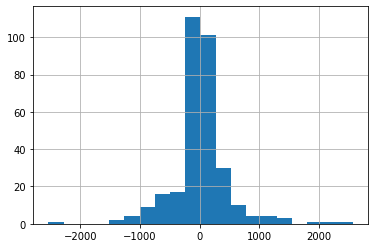

In [37]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
# print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))
df_trade['pnl'].hist(bins=20)